# Tutorial

## Preliminaries

The following set of exampels shows the user how to train an example Masked Autoregressive Flow and an example Kernel Density Estimator then use *bayesstats* to generate estimates of the Kullback Leibler divergence and Bayesian Dimensionality.

The code require [anesthetic](https://pypi.org/project/anesthetic/) to run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from anesthetic.samples import NestedSamples

In order to demonstrate the applications of the code we need to load some example samples from a nested sampling run and we can visualise the posterior distributions with `anesthetic`. We write a helper function to load the chains and transform the parameters in the first three columns, which were generated with a log-uniform prior, into the unifrom space.

In [2]:
def load_chains(root, logs=[]):
    """
    Function uses anesthetic to load in a set of chains and returns
    the pandas table of samples, a numpy
    array of the parameters in the uniform space and weights.
    """

    samples = NestedSamples(root=root)

    try:
        names = ['p' + str(i) for i in range(ndims)]
        theta = samples[names].values
    except:
        names = [i for i in range(ndims)]
        theta = samples[names].values

    for i in range(theta.shape[1]):
        if i in logs:
            theta[:, i] = np.log10(theta[:, i])
    weights = samples.weights

    return samples, theta, weights

ndims=5

root = '../log_prior_gaussian_basic/test'
samples, theta, weights = load_chains(root, logs=[0, 1, 2])


To visualise the posterior we define another helper function that will be useful later in the document.

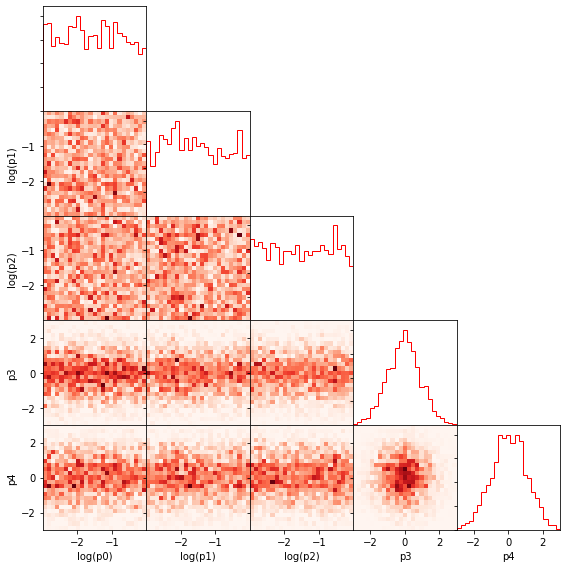

In [3]:
from anesthetic.plot import hist_plot_1d, hist_plot_2d

def plotter(theta, names, w=None, ndims=5):
    """ Helper function that uses anesthetic to produce corner plots """
    fig, axes = plt.subplots(ndims, ndims, figsize=(8, 8), sharex='col')
    for i in range(ndims):
        for j in range(ndims):
            if i < j:
                axes[i, j].axis('off')
            if i == j:
                hist_plot_1d(axes[i, j], theta[:, i], weights=w,
                xmin=theta[:, i].min(), xmax=theta[:, i].max(), color='r',
                histtype='step', bins=25, density=True)
            if i < j:
                hist_plot_2d(axes[j, i], theta[:, i], theta[:, j],
                            weights=w,
                            xmin=theta[:, i].min(), xmax=theta[:, i].max(),
                            ymin=theta[:, j].min(), ymax=theta[:, j].max(),
                            bins=25, density=True, cmap=plt.get_cmap('Reds'))
            if j not in set([0, ndims]):
                axes[i, j].set_yticklabels([])
            if j == 0:
                if i == 0:
                    axes[i, j].set_yticklabels([])
                else:
                    axes[i, j].set_ylabel(names[i])
            if i == ndims-1:
                axes[i, j].set_xlabel(names[j])
    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

names = ['log(p' + str(i) + ')' if i in [0, 1, 2] else 'p' + str(i) for i in range(ndims)]
plotter(theta, names, weights)

## Masked Autoregressive Flows

Firstly we will look at training a Masked Autoregressive Flow or MAF with `bayesstats`. To train the MAF we first need to initalise the class with the samples and corresponding weights.

In [4]:
import os
os.chdir('../')

from bayesstats.maf import MAF

bij = MAF(theta, weights)
bij.train(100)

Epoch: 0 Loss: 0.0016466846
Epoch: 1 Loss: 0.0015112729
Epoch: 2 Loss: 0.0014290371
Epoch: 3 Loss: 0.0013768993
Epoch: 4 Loss: 0.0013418843
Epoch: 5 Loss: 0.0013169803
Epoch: 6 Loss: 0.0012982654
Epoch: 7 Loss: 0.0012834296
Epoch: 8 Loss: 0.0012710348
Epoch: 9 Loss: 0.0012601471
Epoch: 10 Loss: 0.0012501496
Epoch: 11 Loss: 0.0012406617
Epoch: 12 Loss: 0.0012314983
Epoch: 13 Loss: 0.0012226347
Epoch: 14 Loss: 0.0012141657
Epoch: 15 Loss: 0.0012062583
Epoch: 16 Loss: 0.0011991111
Epoch: 17 Loss: 0.0011929104
Epoch: 18 Loss: 0.0011877709
Epoch: 19 Loss: 0.0011836663
Epoch: 20 Loss: 0.0011803736
Epoch: 21 Loss: 0.0011775126
Epoch: 22 Loss: 0.0011746876
Epoch: 23 Loss: 0.0011716645
Epoch: 24 Loss: 0.0011684536
Epoch: 25 Loss: 0.0011652481
Epoch: 26 Loss: 0.0011622747
Epoch: 27 Loss: 0.0011596538
Epoch: 28 Loss: 0.0011573427
Epoch: 29 Loss: 0.0011551846
Epoch: 30 Loss: 0.00115302
Epoch: 31 Loss: 0.001150782
Epoch: 32 Loss: 0.0011485207
Epoch: 33 Loss: 0.00114636
Epoch: 34 Loss: 0.0011444318


We can then generate samples from the bijector using the following code which technically takes samples on the hypercube and transforms them into samples on the target posterior distribution,

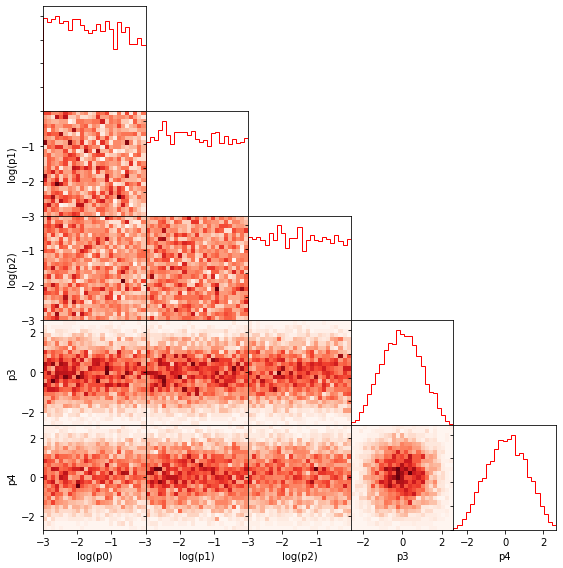

In [5]:
x = bij(np.random.uniform(0, 1, size=(len(theta), theta.shape[-1])))

plotter(x, names)

We can then go ahead an calculate the corresponding kl divergence and Bayesian dimensionality. The samples presented here were generated usign a gaussian likelihood and fitting for 5 parameters as a result we can use `anesthetic` to calculate the KL divergence and Bayesian dimensionality for comparison. We see very similar results.

In [6]:
from bayesstats.marginal_stats import maf_calculations

stats = maf_calculations(bij, x)
print(stats.klDiv(), samples.D())
print(stats.bayesian_dimensionality(), samples.d())

tf.Tensor(0.77126724, shape=(), dtype=float32) 0.7628134849726684
tf.Tensor(1.1860538, shape=(), dtype=float32) 1.7759303343302957


We could imagine that the above set of parameters is a sub-sample of perhaps signal parameters that we are interested in and having marginalised out the nuisance parameters we can use `bayesstats` to determine how well constrained the sub-space is.

As an example we can train a MAF on the final 3 parameters in this distribution.

['log(p1)', 'log(p2)', 'p3']
Epoch: 0 Loss: 0.0008427802
Epoch: 1 Loss: 0.0008183802
Epoch: 2 Loss: 0.00079854066
Epoch: 3 Loss: 0.000781784
Epoch: 4 Loss: 0.0007669133
Epoch: 5 Loss: 0.0007534925
Epoch: 6 Loss: 0.00074162666
Epoch: 7 Loss: 0.0007317382
Epoch: 8 Loss: 0.00072438107
Epoch: 9 Loss: 0.00071999186
Epoch: 10 Loss: 0.0007184975
Epoch: 11 Loss: 0.000719012
Epoch: 12 Loss: 0.00072016905
Epoch: 13 Loss: 0.0007209149
Epoch: 14 Loss: 0.00072082254
Epoch: 15 Loss: 0.0007197673
Epoch: 16 Loss: 0.00071775337
Epoch: 17 Loss: 0.0007151028
Epoch: 18 Loss: 0.00071242364
Epoch: 19 Loss: 0.00071028224
Epoch: 20 Loss: 0.00070890284
Epoch: 21 Loss: 0.0007081346
Epoch: 22 Loss: 0.0007076826
Epoch: 23 Loss: 0.0007073541
Epoch: 24 Loss: 0.00070711976
Epoch: 25 Loss: 0.0007070203
Epoch: 26 Loss: 0.0007070543
Epoch: 27 Loss: 0.0007071449
Epoch: 28 Loss: 0.000707186
Epoch: 29 Loss: 0.0007071101
Epoch: 30 Loss: 0.00070691603
Epoch: 31 Loss: 0.0007066491
Epoch: 32 Loss: 0.000706362
Epoch: 33 Loss: 

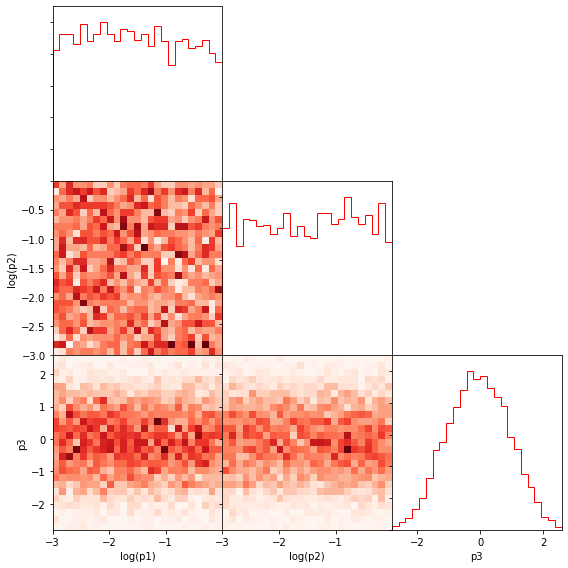

tf.Tensor(0.42065528, shape=(), dtype=float32)
tf.Tensor(0.7356039, shape=(), dtype=float32)


In [7]:
theta_reduced = theta[:, 1:-1]
names_reduced = names[1:-1]

bij = MAF(theta_reduced, weights)
bij.train(100)
x = bij.sample(5000)

plotter(x, names_reduced, ndims=3)

stats = maf_calculations(bij, x)
print(stats.klDiv())
print(stats.bayesian_dimensionality())

# Kernel Density Estimators

We can perform a similar analysis using Kernel Density Estimators rather than MAFs which is done with the following code. Note that the generation of the 'trained' model is significantly quicker than when performed with the MAFs.

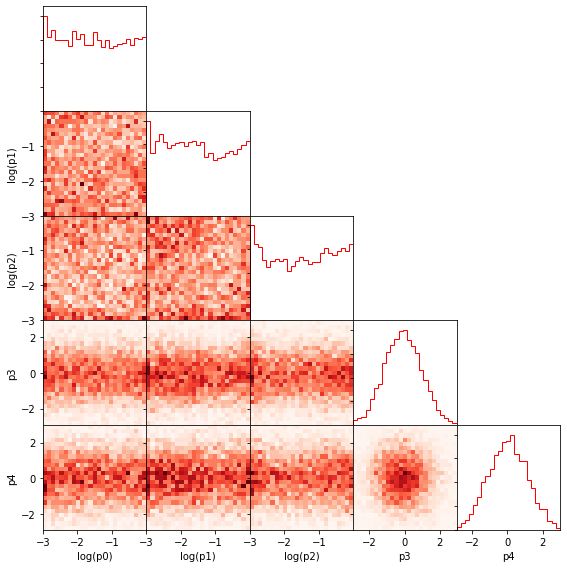

tf.Tensor(0.8017503, shape=(), dtype=float32) 0.7628134849726684
tf.Tensor(1.8362188, shape=(), dtype=float32) 1.7759303343302957


In [12]:
from bayesstats.kde import KDE
kde = KDE(theta, weights)
kde.generate_kde()
x = kde.sample(5000)

plotter(x, names)

from bayesstats.marginal_stats import kde_calculations

stats = kde_calculations(kde, x)
print(stats.klDiv(), samples.D())
print(stats.bayesian_dimensionality(), samples.d())